# Problem Statement¶

The management at Reddit want to improve their ability to perform analysis of text posted to their site. Social media and Tech companies are increasingly being called upon to be responsible for the content on their site. For instance, they may be asked to prevent hate speech that spreads violence, identify threats, and so on. Reddit management decided to hire Dr Monday Oshoikpor(Data scientist and Consultant) to work on this problem and, as a proof-of-concept, to demonstrate the value of machine learning applied to natural language processing.

In response to that challenge, this project specifically attempts to answer the question:
Given a post from one of two subreddits, correctly classify whether or not a post came from the r/LanguageTechnology thread.

* r/LanguageTechnology <=== Target
* r/videos

In [16]:
import requests
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import re


In [17]:
url = 'https://api.pushshift.io/reddit/search/submission' ## base url

In [18]:
## define a function 'process_1_sub' that will extract 20000 posts from chosen subreddit
def process_1_sub(sub):
    params = {
        'subreddit' : sub,
        'size' :20000,
        
    }
    res = requests.get(url, params)
    data = res.json()
    posts = data['data']
    return pd.DataFrame(posts)

In [19]:
## choose some cities , LangaugeTechnology and videos to extract information from
df_lt = process_1_sub('LanguageTechnology')
df_vd = process_1_sub('videos')
df = pd.concat([df_lt, df_vd])
df = df[['subreddit', 'title']]
df

,subreddit,title
0,LanguageTechnology,BART: Denoising Sequence-to-Sequence Pre-train...
1,LanguageTechnology,7 Tips to Quick-start Your Work With Text Usin...
2,LanguageTechnology,Introduction to Natural Language Processing (b...
3,LanguageTechnology,"Objectives of NLP, NLU &amp; NLG"
4,LanguageTechnology,NLP Conferences with a decent industry track?
...,...,...
95,videos,The Legend of Vox Machina - NYCC Live Read wit...
96,videos,Why Fallout: New Vegas is famous for its freedom
97,videos,Roblox Funny Moments - SQUID GAME IN ROBLOX!?
98,videos,CAST - An Animated Short Film


In [20]:
df.shape

(200, 2)

In [21]:
df.info

<bound method DataFrame.info of              subreddit                                              title
0   LanguageTechnology  BART: Denoising Sequence-to-Sequence Pre-train...
1   LanguageTechnology  7 Tips to Quick-start Your Work With Text Usin...
2   LanguageTechnology  Introduction to Natural Language Processing (b...
3   LanguageTechnology                   Objectives of NLP, NLU &amp; NLG
4   LanguageTechnology      NLP Conferences with a decent industry track?
..                 ...                                                ...
95              videos  The Legend of Vox Machina - NYCC Live Read wit...
96              videos   Why Fallout: New Vegas is famous for its freedom
97              videos      Roblox Funny Moments - SQUID GAME IN ROBLOX!?
98              videos                      CAST - An Animated Short Film
99              videos  List of Hot Wheels Unleashed Shortcuts, Racing...

[200 rows x 2 columns]>

In [22]:
df['subreddit'].unique()

array(['LanguageTechnology', 'videos'], dtype=object)

# Data Exploration

In [23]:
df['subreddit'] = df['subreddit'].map({'LanguageTechnology': 1, 'videos': 0}) ## classifying subreddit
df.head()

,subreddit,title
0,1,BART: Denoising Sequence-to-Sequence Pre-train...
1,1,7 Tips to Quick-start Your Work With Text Usin...
2,1,Introduction to Natural Language Processing (b...
3,1,"Objectives of NLP, NLU &amp; NLG"
4,1,NLP Conferences with a decent industry track?


<Figure size 1440x720 with 0 Axes>

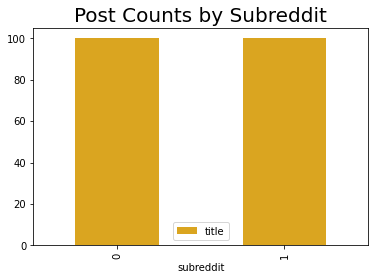

In [24]:
plt.figure(figsize=(20,10))
df.groupby('subreddit').count().plot(kind='bar', color=['goldenrod'])

plt.title('Post Counts by Subreddit', fontsize=20);

In [58]:
df['title'] = df['title'].apply(cleaner)

In [26]:
df

,subreddit,title
0,1,BART: Denoising Sequence-to-Sequence Pre-train...
1,1,7 Tips to Quick-start Your Work With Text Usin...
2,1,Introduction to Natural Language Processing (b...
3,1,"Objectives of NLP, NLU &amp; NLG"
4,1,NLP Conferences with a decent industry track?
...,...,...
95,0,The Legend of Vox Machina - NYCC Live Read wit...
96,0,Why Fallout: New Vegas is famous for its freedom
97,0,Roblox Funny Moments - SQUID GAME IN ROBLOX!?
98,0,CAST - An Animated Short Film


In [27]:
df.shape

(200, 2)

In [28]:
df.duplicated().sum()

3

In [29]:
df[df.duplicated()].head()  ### any duplicate?

,subreddit,title
46,1,Braifun-nlp: A free Natural Language Processin...
33,0,TOURING The Frank Lloyd Wright House in Ebswor...
73,0,Every Haunted House Movie


In [30]:
df[df.duplicated()].tail() ## more duplicate?

,subreddit,title
46,1,Braifun-nlp: A free Natural Language Processin...
33,0,TOURING The Frank Lloyd Wright House in Ebswor...
73,0,Every Haunted House Movie


In [31]:
LanguageTechnology_post = list(df[df.duplicated()]['title'])[0] ### show duplicated titles from LT
LanguageTechnology_post

'Braifun-nlp: A free Natural Language Processing tool to help Researchers brain storm their ideas (Alpha release)'

In [32]:
len(df[df['title'] == LanguageTechnology_post])


2

In [33]:
videos_post = list(df[df.duplicated()]['title'])[0]
videos_post

'Braifun-nlp: A free Natural Language Processing tool to help Researchers brain storm their ideas (Alpha release)'

In [34]:
len(df[df['title'] == videos_post])


2

In [35]:
# look at other duplicate posts
df[df.duplicated() & (df['title'] != LanguageTechnology_post) & (df['title'] != videos_post)].head(10)

,subreddit,title
33,0,TOURING The Frank Lloyd Wright House in Ebswor...
73,0,Every Haunted House Movie


In [36]:
# look at other duplicate posts
df[df.duplicated() & (df['title'] != LanguageTechnology_post) & (df['title'] != videos_post)].tail(10)

,subreddit,title
33,0,TOURING The Frank Lloyd Wright House in Ebswor...
73,0,Every Haunted House Movie


In [37]:
df.shape

(200, 2)

In [38]:
df.drop_duplicates(inplace=True) ## dublicates should go in peace!

In [39]:
df.shape

(197, 2)

In [40]:
## Cleaning!! cleaning!!!
# some of these are redundant with the default functions of CountVectorizer

def cleaner(text):
    # Make lowercase
    text = text.lower()

    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    
    # Remove punctuation and split 's, 't, 've with a space for filter
    text = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', text)
    
    # Remove words with 2 or fewer letters
    text = re.sub(r'\b\w{1,2}\b', '', text)
    
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+', ' ', text)
    
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text = ''.join(c for c in text if c <= '\uFFFF') 
    
    return text
## Adapated from class note on 5.03,5.04,5.05,5.02

In [41]:
df['title'] = df['title'].apply(cleaner)

In [42]:
df.shape

(197, 2)

In [43]:
# drop rows where title = ''
df = df[df['title'] != '']
df = df.reset_index(drop=True)

In [44]:
df.shape

(197, 2)

# Pre-Processing

In [45]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    words = text.split()
    lemma_words = ''
    for word in words:
        lemma_words += (lemmatizer.lemmatize(word) + ' ')
    return lemma_words
## adapted from class note on Language Data Pre-Processing and Sentiment Analysis

In [46]:
df['title'] = df['title'].apply(lemmatize_words)
df

,subreddit,title
0,1,bart denoising sequence sequence pre training ...
1,1,tip quick start your work with text using panda
2,1,introduction natural language processing blog
3,1,objective nlp nlu nlg
4,1,nlp conference with decent industry track
...,...,...
192,0,the legend vox machina nycc live read with ani...
193,0,why fallout new vega famous for it freedom
194,0,roblox funny moment squid game roblox
195,0,cast animated short film


In [47]:
df.shape

(197, 2)

# CountVectorizer

### Most frequent LanguageTechnology words

In [48]:
# Easy way to get most frequently used words: change max_features

count_vect = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = "english", 
                             max_features = 35) 

# input for CountVectorizer is an array of strings
vector_input_LT = df[df['subreddit'] == 1]['title']

# fit_transform the vectorizer
LT_words = count_vect.fit_transform(vector_input_LT)

# convert output to a Numpy array
LT_words = LT_words.toarray()
# adapted from class note on Language Data Pre-Processing and Sentiment Analysis

In [49]:
# get the words
LT_word_list = count_vect.get_feature_names()
print(LT_word_list)

['bert', 'best', 'classification', 'creating', 'data', 'fine', 'free', 'help', 'language', 'learning', 'looking', 'model', 'natural', 'need', 'new', 'nlp', 'pre', 'processing', 'project', 'pytorch', 'question', 'release', 'roberta', 'speech', 'text', 'topic', 'trained', 'training', 'transformer', 'tuning', 'understand', 'using', 'way', 'word', 'work']


In [50]:
# Easy way to get most frequently used words: change max_features

count_vect = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = "english", 
                             max_features = 36) 

# input for CountVectorizer is an array of strings
vector_input_videos = df[df['subreddit'] == 0]['title']

# fit_transform the vectorizer
vd_words = count_vect.fit_transform(vector_input_videos)

# convert output to a Numpy array
vd_words = vd_words.toarray()

In [51]:
# get the words
vd_word_list = count_vect.get_feature_names()
print(vd_word_list)

['beat', 'change', 'check', 'city', 'coffee', 'current', 'dread', 'free', 'freedom', 'game', 'halloween', 'history', 'hot', 'house', 'human', 'ing', 'just', 'know', 'moment', 'movie', 'new', 'night', 'nycc', 'official', 'review', 'short', 'shortcut', 'shy', 'siri', 'smash', 'sora', 'thing', 'time', 'treasure', 'unleashed', 'video']


### edit stop words

#### add non-meaningful words from the "most frequent" lists above to the stop words dictionary

In [52]:
from sklearn.feature_extraction import text

text.ENGLISH_STOP_WORDS

add_stop_words = ['did', 'doe', 'don', 'doesn', 'getting', 'going', 'got', 'ha', 'isn', 'wa']

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

### LanguageTechnology Versus videos 100 words

In [53]:
# THE GOAL IS TO FIND  100 FROM EACH subreddit that are same & to also find the  difference

In [54]:
# Instantiate 'CountVectorizer' object and 'CountVectorizer' transformer

count_vect = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = stop_words, 
                             max_features = 10000, 
                             ngram_range=(1, 3)
                            ) 

# input for CountVectorizer is an array of strings
vector_input_lt = df[df['subreddit'] == 1]['title']

# fit_transform the vectorizer
lt_words = count_vect.fit_transform(vector_input_lt)

# convert output to a Numpy array
lt_words = lt_words.toarray()


In [55]:
lt_matrix = pd.DataFrame(lt_words, columns=count_vect.get_feature_names())

lt_matrix.sum().sort_values(ascending=False).head(20)

nlp                            26
model                          20
text                           14
language                        9
data                            9
new                             8
using                           8
training                        7
bert                            7
transformer                     6
nlp project                     5
project                         5
looking                         5
language processing             5
pre                             5
processing                      5
natural                         5
natural language                5
natural language processing     5
tuning                          4
dtype: int64

In [ ]:
description_list = df['description'].values.tolist()

from collections import Counter
Counter(" ".join(description_list).split()).most_common(10)

#histogram 
plt.bar(x, y)
plt.title("10 most frequent tokens in description")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show

In [290]:
lt_mean = lt_matrix.mean().sort_values(ascending=False) ### mean of lt_matrix
lt_mean.head()

nlp      0.252525
model    0.202020
text     0.151515
new      0.090909
data     0.090909
dtype: float64

(array([1.187e+03, 1.290e+02, 1.400e+01, 1.200e+01, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([0.0010616 , 0.0040564 , 0.00705121, 0.01004601, 0.01304082,
        0.01603563, 0.01903043, 0.02202524, 0.02502004, 0.02801485,
        0.03100966]),
 <BarContainer object of 10 artists>)

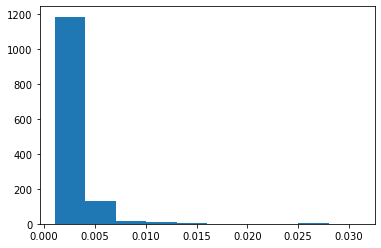

In [256]:
counts, bins = np.histogram(lt_mean)
plt.hist(bins[:-1], bins, weights=counts)

In [203]:
count_vect = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = stop_words, 
                             max_features = 10000, 
                             ngram_range=(1, 3)
                            ) 

# input for CountVectorizer is an array of strings
vector_input_vd = df[df['subreddit'] == 0]['title']

# fit_transform the vectorizer
vd_words = count_vect.fit_transform(vector_input_vd)

# convert output to a Numpy array
vd_words = vd_words.toarray()


In [204]:
vd_matrix = pd.DataFrame(vd_words, columns=count_vect.get_feature_names())

vd_matrix.sum().sort_values(ascending=False).head(50)


video                    6
home                     4
official                 3
internet                 3
baby                     3
movie                    3
talk                     3
best                     3
dog                      3
like                     3
mod                      3
trailer                  3
tour                     3
reddit                   3
new                      3
bonanza                  2
anti                     2
squid game               2
style                    2
rice                     2
cambium                  2
cambium cada             2
2019                     2
cambium cada segundos    2
world                    2
rick                     2
mapa                     2
mapa cambium             2
mapa cambium cada        2
archive                  2
2021                     2
season                   2
man                      2
elementor                2
rewind                   2
house                    2
spiderman                2
w

In [258]:
vd_mean = vd_matrix.mean().sort_values(ascending=False) ## mean of videos_matrix
vd_mean.head()

home        0.016995
video       0.011489
niko        0.010526
catching    0.008549
internet    0.008329
dtype: float64

(array([982., 192.,  41.,  23.,   4.,   1.,   1.,   0.,   0.,   1.]),
 array([0.0015578, 0.0031015, 0.0046452, 0.0061889, 0.0077326, 0.0092763,
        0.01082  , 0.0123637, 0.0139074, 0.0154511, 0.0169948]),
 <BarContainer object of 10 artists>)

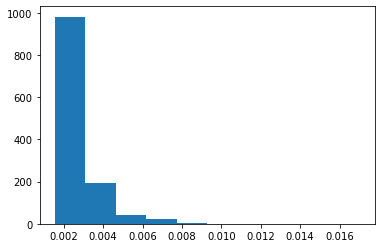

In [259]:
counts, bins = np.histogram(vd_mean)
plt.hist(bins[:-1], bins, weights=counts)

### TF-IDF Vectorizer

In [208]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
tvec = TfidfVectorizer(analyzer = "word", 
                     stop_words = stop_words, 
                     max_features = 10000, 
                     ngram_range = (1, 3))

lt_tf_words = tvec.fit_transform(vector_input_lt)

lt_tf_words = lt_tf_words.toarray()

lt_matrix = pd.DataFrame(lt_tf_words, columns=tvec.get_feature_names())

lt_matrix.sum().sort_values(ascending=False).head(50)

## adapted from note on Language Data Pre-Processing and Sentiment Analysis

nlp                            3.069956
text                           2.525735
model                          2.512918
language                       1.601680
data                           1.506639
bert                           1.378259
looking                        1.254535
processing                     1.223963
nlp project                    1.202099
project                        1.202099
new                            1.191234
using                          1.149503
fine                           1.107088
fine tuning                    1.107088
tuning                         1.107088
transformer                    1.043918
ubiai                          1.000000
customize                      1.000000
question                       0.984188
pre                            0.971465
training                       0.970766
help                           0.914796
natural                        0.909154
natural language               0.909154
natural language processing    0.909154


In [209]:
tvec = TfidfVectorizer(analyzer = "word", 
                     stop_words = stop_words, 
                     max_features = 10000, 
                     ngram_range = (1, 3))

vd_tf_words = tvec.fit_transform(vector_input_vd)

vd_tf_words = vd_tf_words.toarray()

vd_matrix = pd.DataFrame(vd_tf_words, columns=tvec.get_feature_names())

vd_matrix.sum().sort_values(ascending=False).head(50)


home                    1.614506
video                   1.091477
niko                    1.000000
catching                0.812192
internet                0.791234
facebook                0.763781
new                     0.754858
movie                   0.733742
dog                     0.718643
hacker                  0.707107
reddit                  0.704859
best                    0.701212
spiderman               0.696792
time                    0.696565
make                    0.690498
sora                    0.687677
official                0.676624
trailer                 0.673146
game                    0.638074
squid game              0.638074
squid                   0.638074
like                    0.632840
way                     0.628601
archive                 0.621381
man                     0.618610
mod                     0.614561
try catching            0.593343
facebook disappeared    0.593343
disappeared             0.593343
try                     0.593343
heaven    

## set up X and y, train/test split

In [219]:
X = df['title']
y = df['subreddit']

In [220]:
y.value_counts(normalize=True) ## almost 50% make it right

1    0.510309
0    0.489691
Name: subreddit, dtype: float64

In [221]:
# define training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

### edit stop words

In [222]:
from sklearn.feature_extraction import text

text.ENGLISH_STOP_WORDS

add_stop_words = ['did', 'doe', 'don', 'doesn', 'getting', 'going', 'got', 'ha', 'isn', 'wa']

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)


In [223]:
stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

# Modeling

I created and designed three different model in hope to have the best score to make predictions.

## Logistic Regression with CountVectorizer¶

In [260]:
#Logistic regression with count vectorizer
pipe = Pipeline([
    ('cvec', CountVectorizer()),   #count vectorizor
    ('lr', LogisticRegression())     #model 
])

In [261]:
params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [50, 100, 500, 1000, 1500],      #iterate over these options to see what is best
    'cvec__min_df': [2,3,5],
    'cvec__max_df': [.75, .8, .9, .95],
    'lr__random_state': [42]
    ##### note you could add 'cvec_tokenizer' : [None, custom_tokenizer]
}
gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X_train, y_train) # Also does cv in the background
print(f'gs.best.score_: {gs.best_score_}') # cross_val_score
print(f'gs.best.params_: {gs.best_params_}')
gs.best_estimator_

gs.best.score_: 0.8062015503875969
gs.best.params_: {'cvec__max_df': 0.75, 'cvec__max_features': 100, 'cvec__min_df': 2, 'cvec__stop_words': None, 'lr__random_state': 42}


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.75, max_features=100, min_df=2)),
                ('lr', LogisticRegression(random_state=42))])

In [262]:
print(f'Train Score GS1A: {gs.score(X_train,y_train)}')
print(f'Test Score GS1A: {gs.score(X_test,y_test)}')

Train Score GS1A: 0.8992248062015504
Test Score GS1A: 0.7692307692307693


In [263]:
params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [10, 25, 50],      #iterate over these options to see what is best
    'cvec__min_df': [2,3,5],
    'cvec__max_df': [.75, .8, .9, .95],
    'lr__random_state': [42]
}

gs = GridSearchCV(pipe, param_grid=params, cv=3)
gs.fit(X_train, y_train) # Also does cv in the background

print(f'gs.best.score_: {gs.best_score_}') # cross_val_score
print(f'gs.best.params_: {gs.best_params_}')
gs.best_estimator_


gs.best.score_: 0.7984496124031008
gs.best.params_: {'cvec__max_df': 0.75, 'cvec__max_features': 25, 'cvec__min_df': 2, 'cvec__stop_words': None, 'lr__random_state': 42}


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.75, max_features=25, min_df=2)),
                ('lr', LogisticRegression(random_state=42))])

In [264]:
print(f'Train Score GS1B: {gs.score(X_train,y_train)}')
print(f'Test Score GS1B: {gs.score(X_test,y_test)}')

Train Score GS1B: 0.8682170542635659
Test Score GS1B: 0.7692307692307693


Despite changing max_features, the Logistic Regression with CountVectorizer remained the same at 77%

## KNN with Tfidf

In [266]:
from sklearn.neighbors import KNeighborsClassifier
#KNN with Tfidf
pipe3 = Pipeline([
    ('tfidf', TfidfVectorizer()),   #Tfidf vectorizor  
    ('knn', KNeighborsClassifier(n_neighbors=20))        #model 
])

In [267]:

params3 = {
        'tfidf__stop_words': [None, 'english'],
        'tfidf__max_features': [10, 25, 50],      #iterate over these options to see what is best
        'tfidf__min_df': [2, 3, 5],
        'tfidf__max_df': [.75, .8, .9, .95]
}
gs3 = GridSearchCV(pipe3, param_grid=params3, cv=3)
gs3.fit(X_train, y_train) # Also does cv in the background

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('knn',
                                        KNeighborsClassifier(n_neighbors=20))]),
             param_grid={'tfidf__max_df': [0.75, 0.8, 0.9, 0.95],
                         'tfidf__max_features': [10, 25, 50],
                         'tfidf__min_df': [2, 3, 5],
                         'tfidf__stop_words': [None, 'english']})

In [268]:
print(f'gs3.best.score_: {gs3.best_score_}') # cross_val_score
print(f'gs3.best.params_: {gs3.best_params_}')
gs3.best_estimator_

gs3.best.score_: 0.7441860465116279
gs3.best.params_: {'tfidf__max_df': 0.75, 'tfidf__max_features': 10, 'tfidf__min_df': 5, 'tfidf__stop_words': 'english'}


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, max_features=10, min_df=5,
                                 stop_words='english')),
                ('knn', KNeighborsClassifier(n_neighbors=20))])

In [269]:
print(f'Train Score GS3A: {gs3.score(X_train,y_train)}')
print(f'Test Score GS3A: {gs3.score(X_test,y_test)}')

Train Score GS3A: 0.7209302325581395
Test Score GS3A: 0.6923076923076923


In [276]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

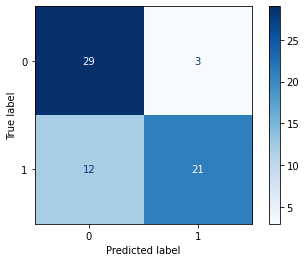

In [277]:
# View confusion matrix

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');


## Random Forestm with Tfidf

In [270]:
#KNN with Tfidf
pipe4 = Pipeline([
    ('tfidf', TfidfVectorizer()),   #Tfidf vectorizor  
    ('rf', RandomForestClassifier(random_state=42))        #model 
])

In [271]:
params4 = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [10, 25, 50],      #iterate over these options to see what is best
    'tfidf__min_df': [2, 3, 5],
    'tfidf__max_df': [.75, .8, .9, .95],
    'rf__n_estimators': [10, 50, 100],  #to get rid of warnings
    'rf__max_depth': [None, 3, 5],
    'rf__max_features': ['auto']  #auto is default
   }   
gs4 = GridSearchCV(pipe4, param_grid=params4, cv=5)
gs4.fit(X_train, y_train) # Also does cv in the background
print(f'gs4.best.score_: {gs4.best_score_}') # cross_val_score
print(f'gs4.best.params_: {gs4.best_params_}')
gs4.best_estimator_

gs4.best.score_: 0.8532307692307693
gs4.best.params_: {'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 50, 'tfidf__max_df': 0.75, 'tfidf__max_features': 50, 'tfidf__min_df': 2, 'tfidf__stop_words': 'english'}


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.75, max_features=50, min_df=2,
                                 stop_words='english')),
                ('rf',
                 RandomForestClassifier(n_estimators=50, random_state=42))])

In [272]:
print(f'Train Score GS4A: {gs4.score(X_train,y_train)}')
print(f'Test Score GS4A: {gs4.score(X_test,y_test)}')

Train Score GS4A: 0.9224806201550387
Test Score GS4A: 0.7384615384615385


In [274]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

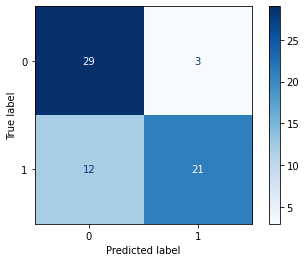

In [275]:
# View confusion matrix

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

# Conclusion

**The performance of the models is summarized below**:


* Baseline Model Accuracy - 50%

* Accuracy achieved by KNN with Tfidf - 69%


* Accuracy with Logistic Regression with CountVectorizer - 77%



* Accuracy achieved by Random Forest Classifier - 74%


* The algorithms  beat the baseline accuracy, but Logistic Regression with CountVectorizer  scored higher than KNN with Tfidf and Random forest Classifier on an accuracy score  approximately 77%.


* Therefore, our model successfully classify r/LanguageTechnology, and non r/LanguageTechnology, with a 77% of the time.

# Recommendation

Extract more submissions.Use different models to score the algorithms.

# References

https://hbr.org/2021/01/social-media-companies-should-self-regulate-now